# 事例3: LIGOの重力波解析を経験する

- ### LIGOのサイト: https://losc.ligo.org/events/
- ### <a href='https://losc.ligo.org/s/events/LOSC_Event_tutorial_GW150914.html'>このチュートリアル</a>をベースにしている

## 3-1 観測･実験：観測波を確認する
<img src="pyconfig1.png">

- ### パラメータをきめて，必要なパッケージを読み込む．

In [1]:
eventname = 'GW150914' 
plottype = "png"

In [2]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
import readligo as rl

- ### いくつかのプリセット設定はjsonファイルに書いてあるので読み込み，設定を変数に格納

In [3]:
events = json.load(open("O1_events.json","r"))

In [4]:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

Reading in parameters for event GW150914
{u'fband': [43.0, 300.0], u'approx': u'lalsim.SEOBNRv2', u'fs': 4096, u'name': u'GW150914', u'URL': u'https://losc.ligo.org/s/events/GW150914/', u'utcevent': u'2015-09-14T09:50:45.44', u'fn_H1': u'H-H1_LOSC_4_V1-1126259446-32.hdf5', u'a1': 0.355, u'fn_L1': u'L-L1_LOSC_4_V1-1126259446-32.hdf5', u'm1': 41.743, u'f_min': 10.0, u'fn_template': u'GW150914_4_template.hdf5', u'm2': 29.237, u'tevent': 1126259462.44, u'a2': -0.769}


- ### サンプリングレートは4096Hz

- ### 設定ファイルにある重力波データを読み込む

In [5]:
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

- ### H1, L1を眺める

In [6]:
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
 

('time_H1: len, min, mean, max = ', 131072, 1126259446.0, 1126259461.9998779, 1126259477.9997559)
('strain_H1: len, min, mean, max = ', 131072, -7.1199633870861168e-19, 8.7327979405714843e-23, 7.7148363376537864e-19)
('strain_L1: len, min, mean, max = ', 131072, -2.678808917297832e-18, -1.8287074918910352e-18, -7.692661770244014e-19)
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA


- ### H1, L1をプロット

1126259462.44


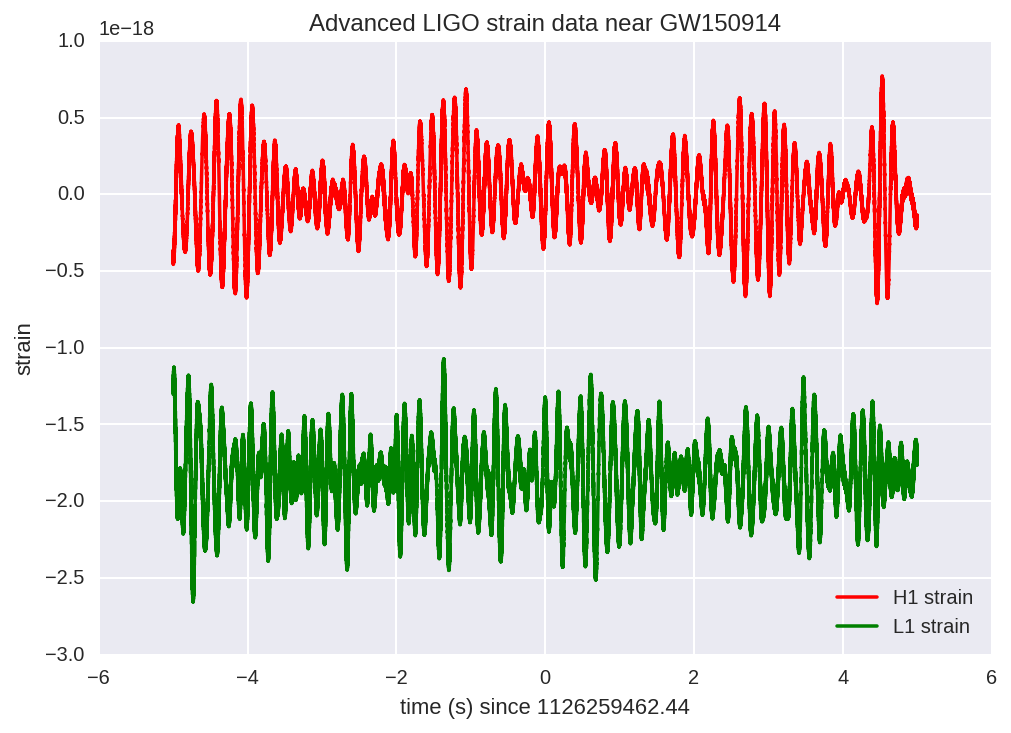

In [7]:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
print(tevent)

plt.figure()
plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower right')
plt.title('Advanced LIGO strain data near '+eventname)
plt.savefig(eventname+'_strain.'+plottype)

- ### 低周波ノイズが激しい．これを信号処理で取り除きたい．

- ### 振幅スペクトラル密度（パワースペクトラル密度の二乗根)の状況をみたい．
- ### パワースペクトラル密度はFFTでも計算できるが，matplotlibのpsdで一発で求まる．

In [8]:
NFFT = 4*fs
Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)

Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
psd_smooth = interp1d(freqs, Pxx)

- ### 20Hz以下は観測装置のカリブレーション外．
- ### サンプリングレートが4096Hz，ということはナイキスト周波数が2048Hz．
- ### 標本化定理により2000Hz以下をとる．

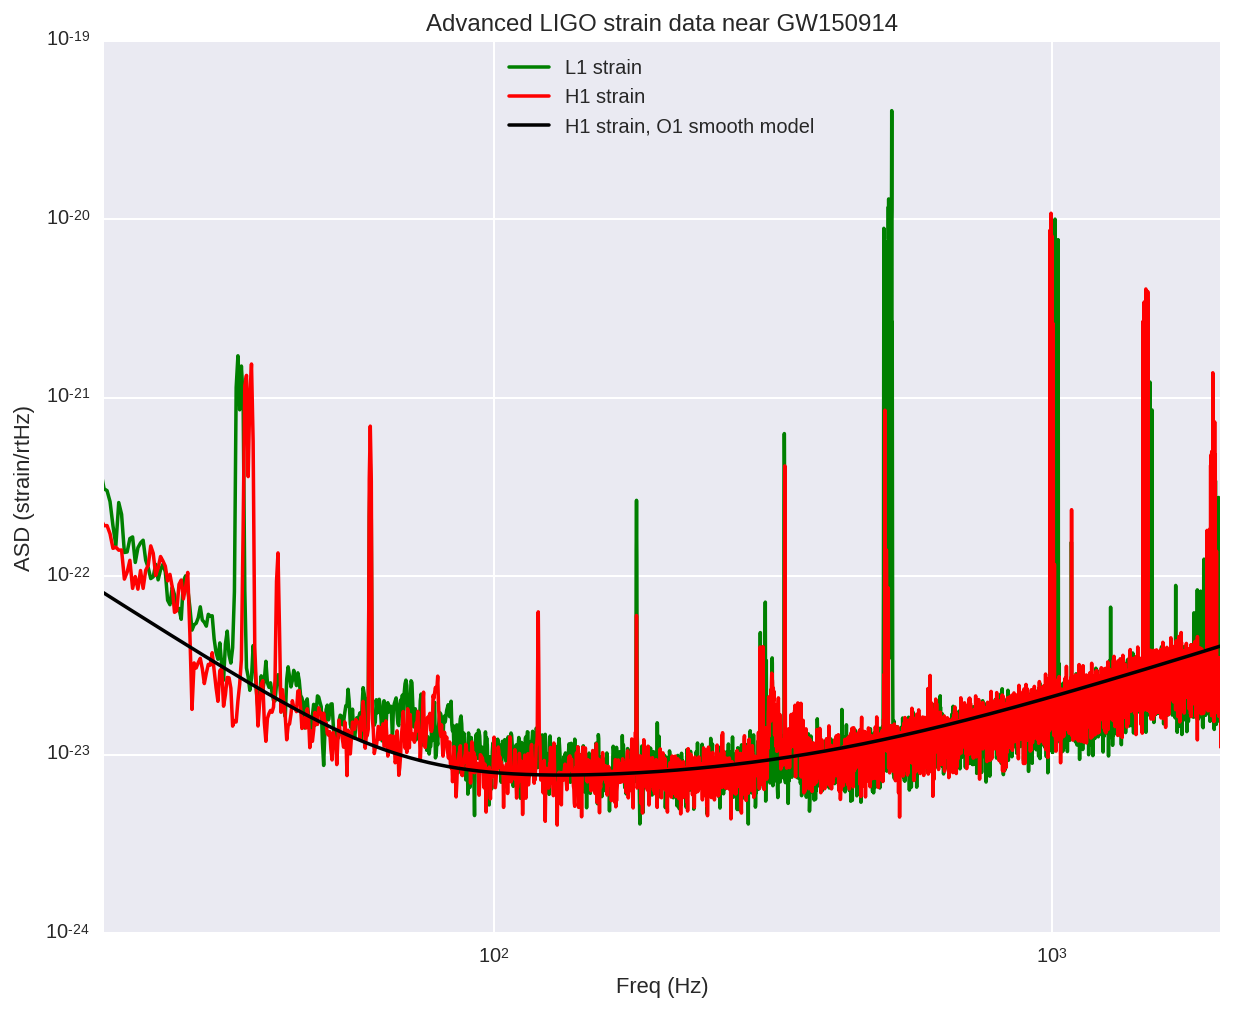

In [9]:
f_min = 20.
f_max = 2000. 
fig = plt.figure(figsize=(10,8))
plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')
plt.axis([f_min, f_max, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near '+eventname)
plt.savefig(eventname+'_ASDs.'+plottype)

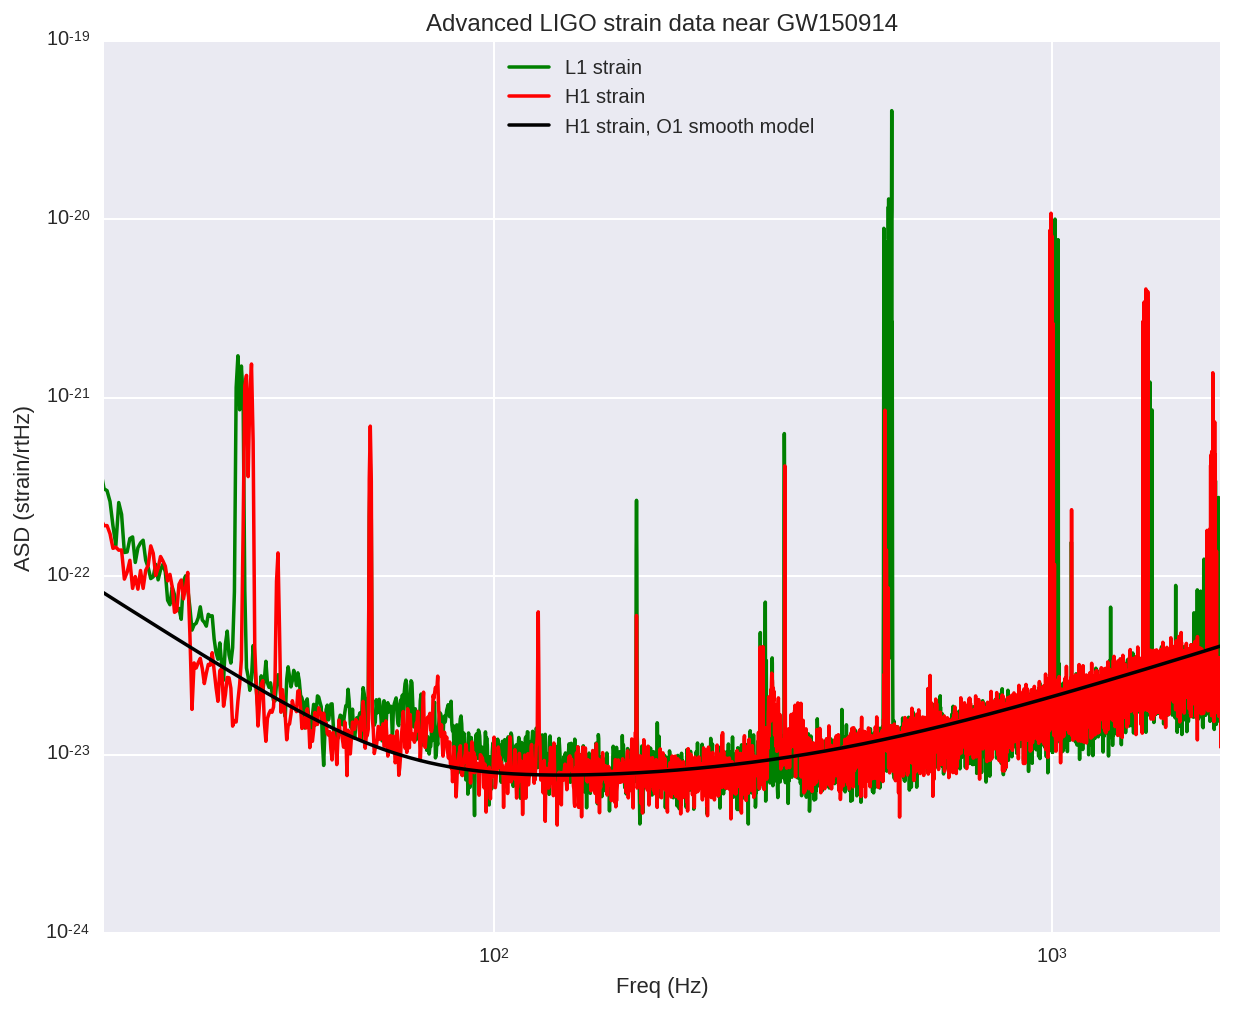

In [10]:
fig

- ### ASDを見ると超汚れている
- ### 80Hz - 300Hzではフラット
- ### この波形を白色化したい

## 3-2 整理：観測波を白色化する
<img src="pyconfig2.png">

- ### 白色化は，フーリエ空間で自分自身のASDで割り込み，戻す

In [11]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

- ### H1, L1に白色化適用

In [12]:
# now whiten the data from H1 and L1, and the template (use H1 PSD):
strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
strain_L1_whiten = whiten(strain_L1,psd_L1,dt)

# We need to suppress the high frequency noise (no signal!) with some bandpassing:
bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)
strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten)

- ### 白色できたかスペクトログラムで確認
- ### まずはH1

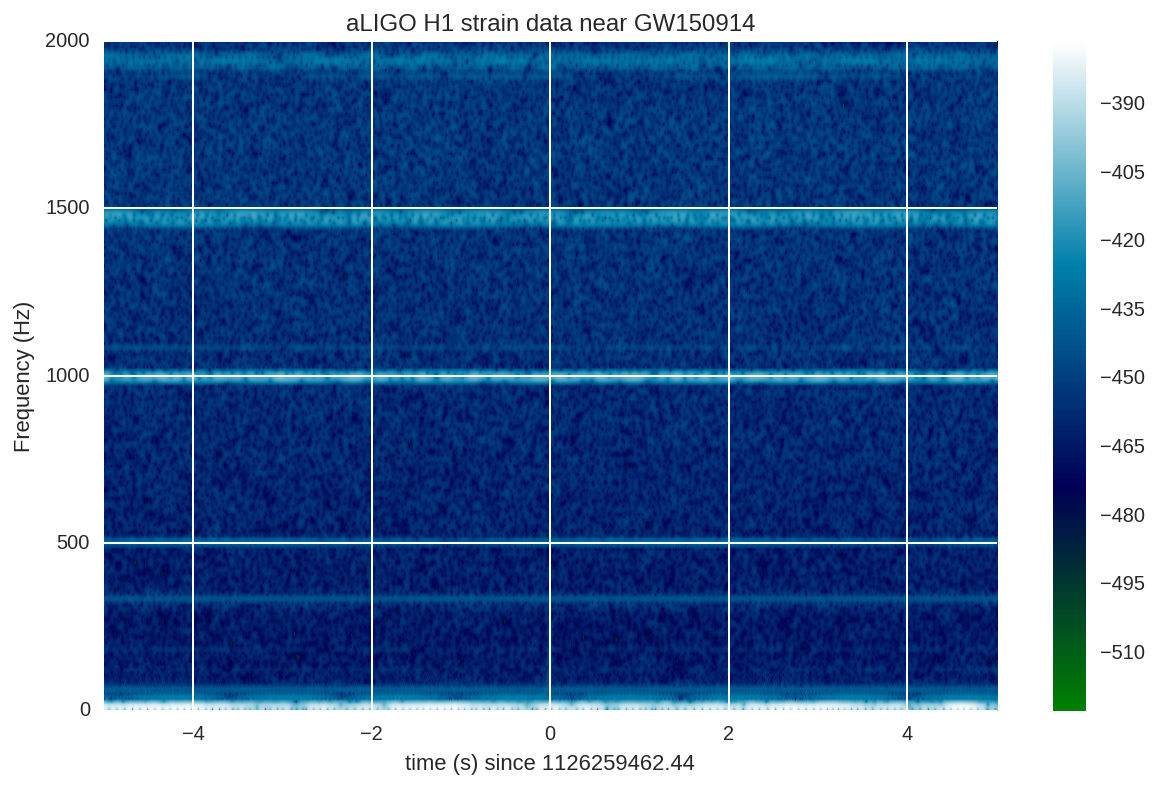

In [13]:
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
NFFT = int(fs/8)
NOVL = int(NFFT*15./16)
window = np.blackman(NFFT)

spec_cmap='ocean'
fig1 = plt.figure(figsize=(10,6))
spec_H1, freqs, bins, im = plt.specgram(strain_H1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 2000])
plt.title('aLIGO H1 strain data near '+eventname)
plt.savefig(eventname+'_H1_spectrogram.'+plottype)

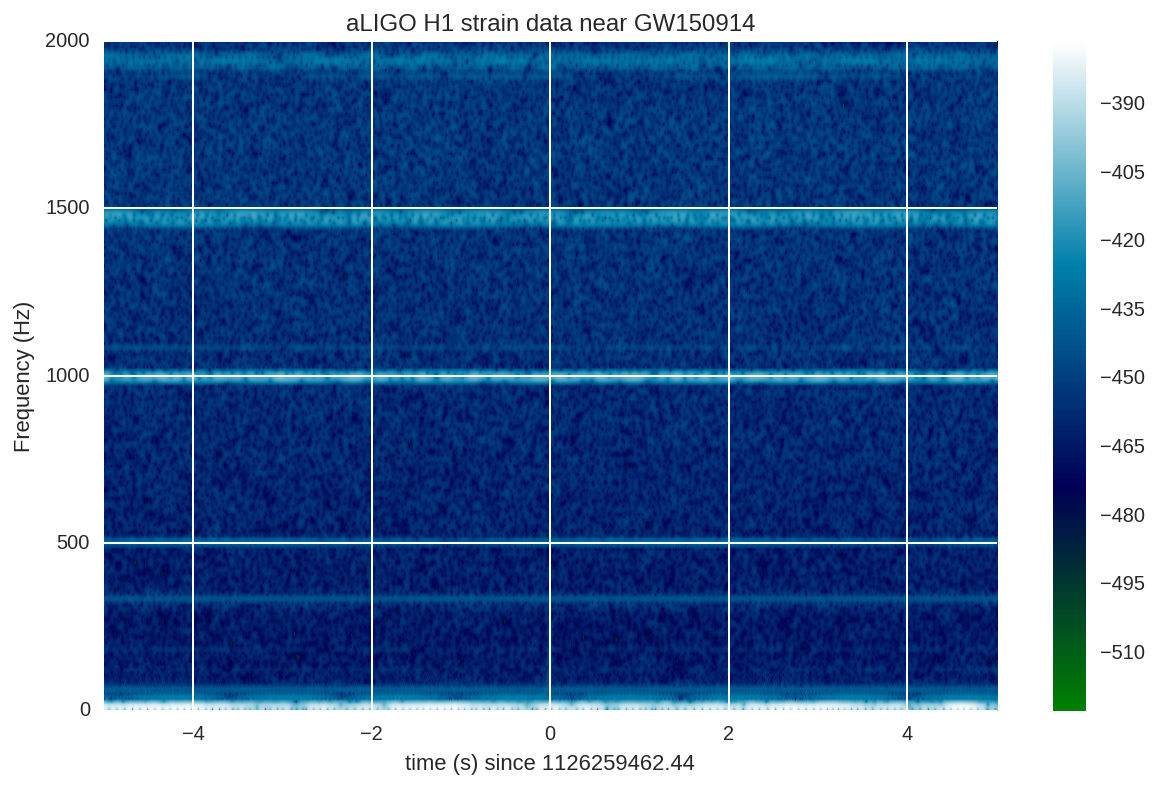

In [14]:
fig1

- ### ~20 Hz以下にスペクトル線がたくさんある
- ### 500, 1000, 1500 Hz に強いスペクトル線がでている
- ### うまく白色化できたよう

- ### 次にL1

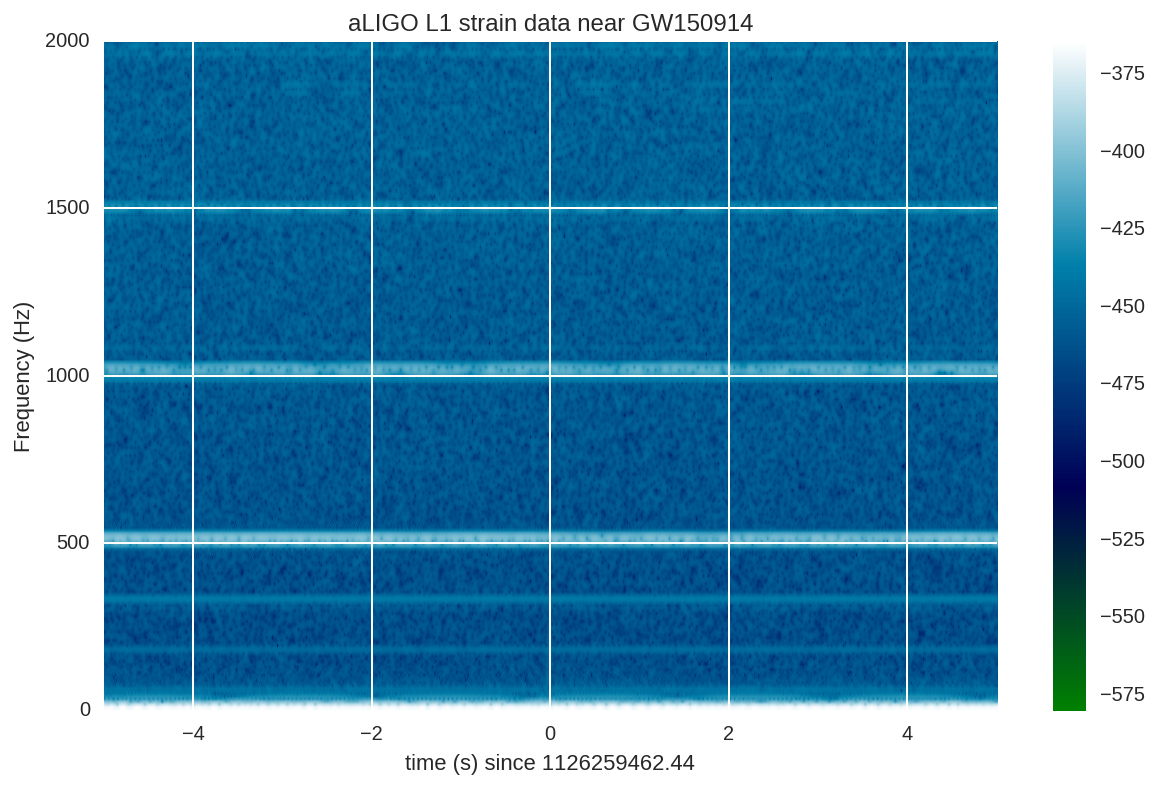

In [15]:
plt.figure(figsize=(10,6))
spec_H1, freqs, bins, im = plt.specgram(strain_L1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 2000])
plt.title('aLIGO L1 strain data near '+eventname)
plt.savefig(eventname+'_L1_spectrogram.'+plottype)

- ### H1を拡大プロット

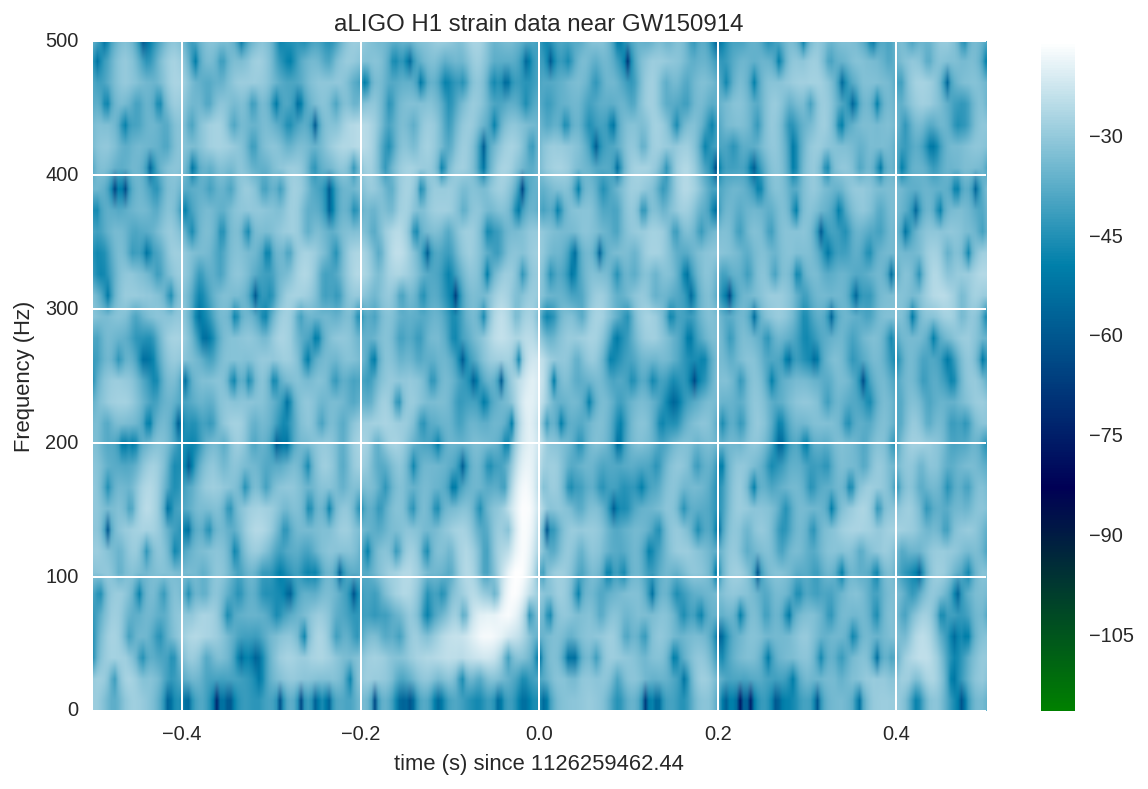

In [16]:
NFFT = int(fs/16.0)
NOVL = int(NFFT*15/16.0)
window = np.blackman(NFFT)

fig1 = plt.figure(figsize=(10,6))
spec_H1, freqs, bins, im = plt.specgram(strain_H1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])
plt.title('aLIGO H1 strain data near '+eventname)
plt.savefig(eventname+'_H1_spectrogram_whitened.'+plottype)

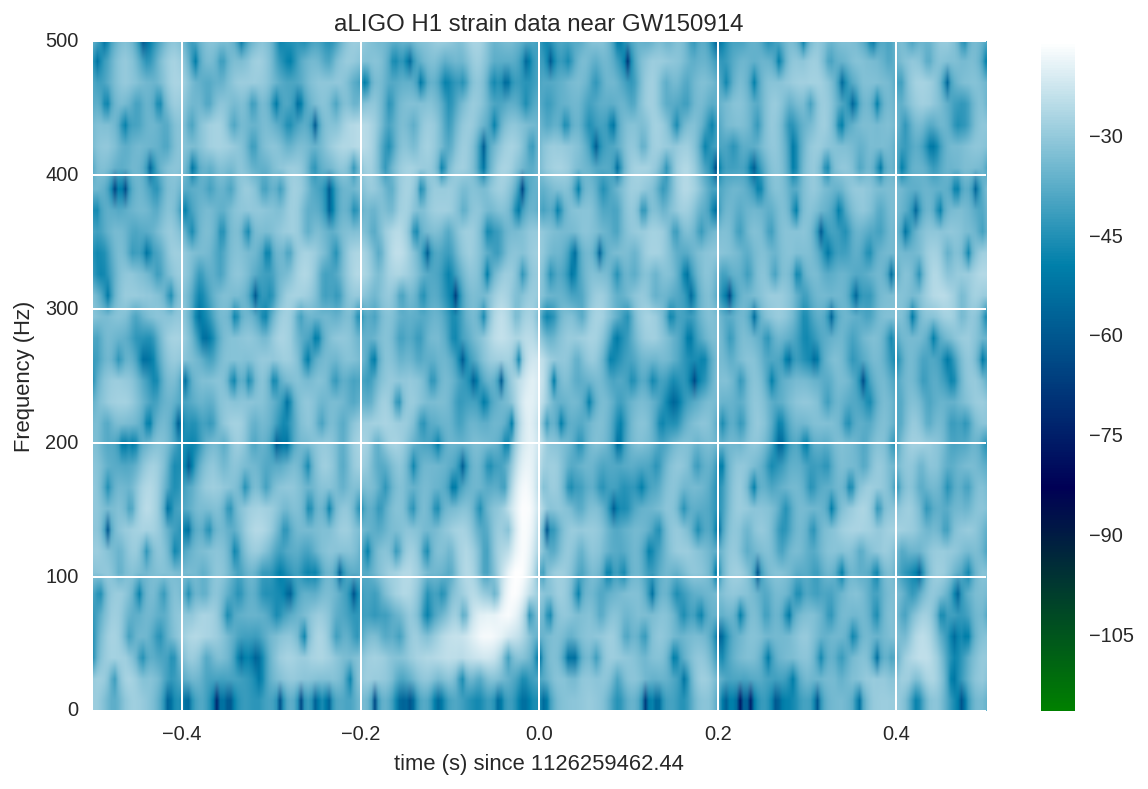

In [17]:
fig1

- ### 明らかにchirpが現れている．

- ### L2も同様に拡大プロット．

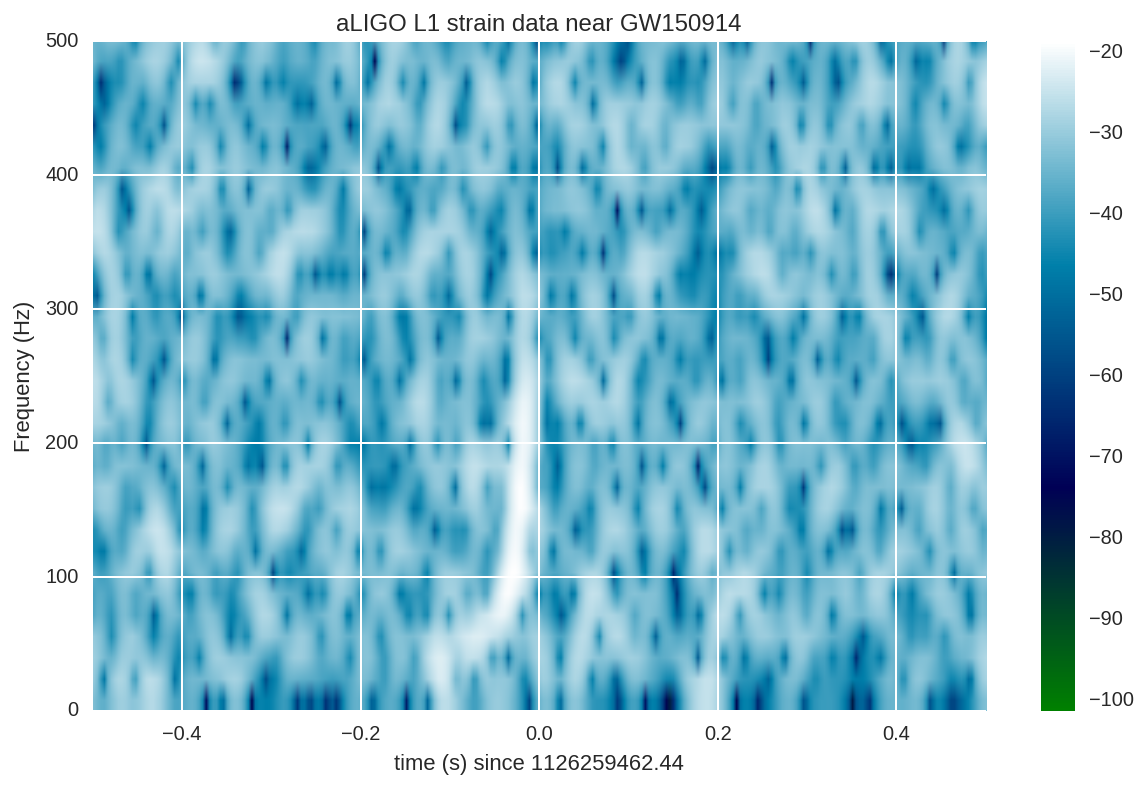

In [18]:
# Plot the L1 whitened spectrogram around the signal
plt.figure(figsize=(10,6))
spec_H1, freqs, bins, im = plt.specgram(strain_L1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])
plt.title('aLIGO L1 strain data near '+eventname)
plt.savefig(eventname+'_L1_spectrogram_whitened.'+plottype)

## 3-3 仮説・モデル：一般相対性理論＋BH連星のモデル
<img src="pyconfig3.png">

- ### 仮説：一般相対性理論による重力波理論
- ### モデル：ブラックホール連星の理論モデル
- ### 数値シミュレーション -> 重力波のchirp
- ### その計算結果を読み込む

In [19]:
# read in the template (plus and cross) and parameters for the theoretical waveform
f_template = h5py.File(fn_template, "r")

- ### 変数等を格納する

In [20]:
# extract metadata from the template file:
template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

# whiten the templates:
template_p_whiten = whiten(template_p,psd_H1,dt)
template_c_whiten = whiten(template_c,psd_H1,dt)
template_p_whitenbp = filtfilt(bb, ab, template_p_whiten)
template_c_whitenbp = filtfilt(bb, ab, template_c_whiten)

- ### 準備

In [21]:
# constants:
clight = 2.99792458e8                # m/s
G = 6.67259e-11                      # m^3/kg/s^2 
MSol = 1.989e30                      # kg

# template parameters: masses in units of MSol:
t_mtot = t_m1+t_m2
# final BH mass is typically 95% of the total initial mass:
t_mfin = t_mtot*0.95
# Final BH radius, in km:
R_fin = 2*G*t_mfin*MSol/clight**2/1000.

# complex template:
template = (template_p + template_c*1.j) 
ttime = time-time[0]-template_offset

# compute the instantaneous frequency of this chirp-like signal:
tphase = np.unwrap(np.angle(template))
fGW = np.gradient(tphase)*fs/(2.*np.pi)
# fix discontinuities at the very end:
iffix = np.where(np.abs(np.gradient(fGW)) > 100.)[0]
fGW[iffix] = fGW[iffix[0]-1]
fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]

# compute v/c:
voverc = (G*t_mtot*MSol*np.pi*fGW/clight**3)**(1./3.)

# index where f_GW is in-band:
f_inband = fband[0]
iband = np.where(fGW > f_inband)[0][0]
# index at the peak of the waveform:
ipeak = np.argmax(np.abs(template))

# number of cycles between inband and peak:
Ncycles = (tphase[ipeak]-tphase[iband])/(2.*np.pi)

print('Properties of waveform template in {0}'.format(fn_template))
print("Waveform family = {0}".format(t_approx))
print("Masses = {0:.2f}, {1:.2f} Msun".format(t_m1,t_m2))
print('Mtot = {0:.2f} Msun, mfinal = {1:.2f} Msun '.format(t_mtot,t_mfin))
print("Spins = {0:.2f}, {1:.2f}".format(t_a1,t_a2))
print('Freq at inband, peak = {0:.2f}, {1:.2f} Hz'.format(fGW[iband],fGW[ipeak]))
print('Time at inband, peak = {0:.2f}, {1:.2f} s'.format(ttime[iband],ttime[ipeak]))
print('Duration (s) inband-peak = {0:.2f} s'.format(ttime[ipeak]-ttime[iband]))
print('N_cycles inband-peak = {0:.0f}'.format(Ncycles))
print('v/c at peak = {0:.2f}'.format(voverc[ipeak]))
print('Radius of final BH = {0:.0f} km'.format(R_fin))

Properties of waveform template in GW150914_4_template.hdf5
Waveform family = lalsim.SEOBNRv2
Masses = 41.74, 29.24 Msun
Mtot = 70.98 Msun, mfinal = 67.43 Msun 
Spins = 0.35, -0.77
Freq at inband, peak = 43.05, 169.84 Hz
Time at inband, peak = -0.08, -0.02 s
Duration (s) inband-peak = 0.06 s
N_cycles inband-peak = 4
v/c at peak = 0.57
Radius of final BH = 199 km


- ### 読み込めたかどうかプロット

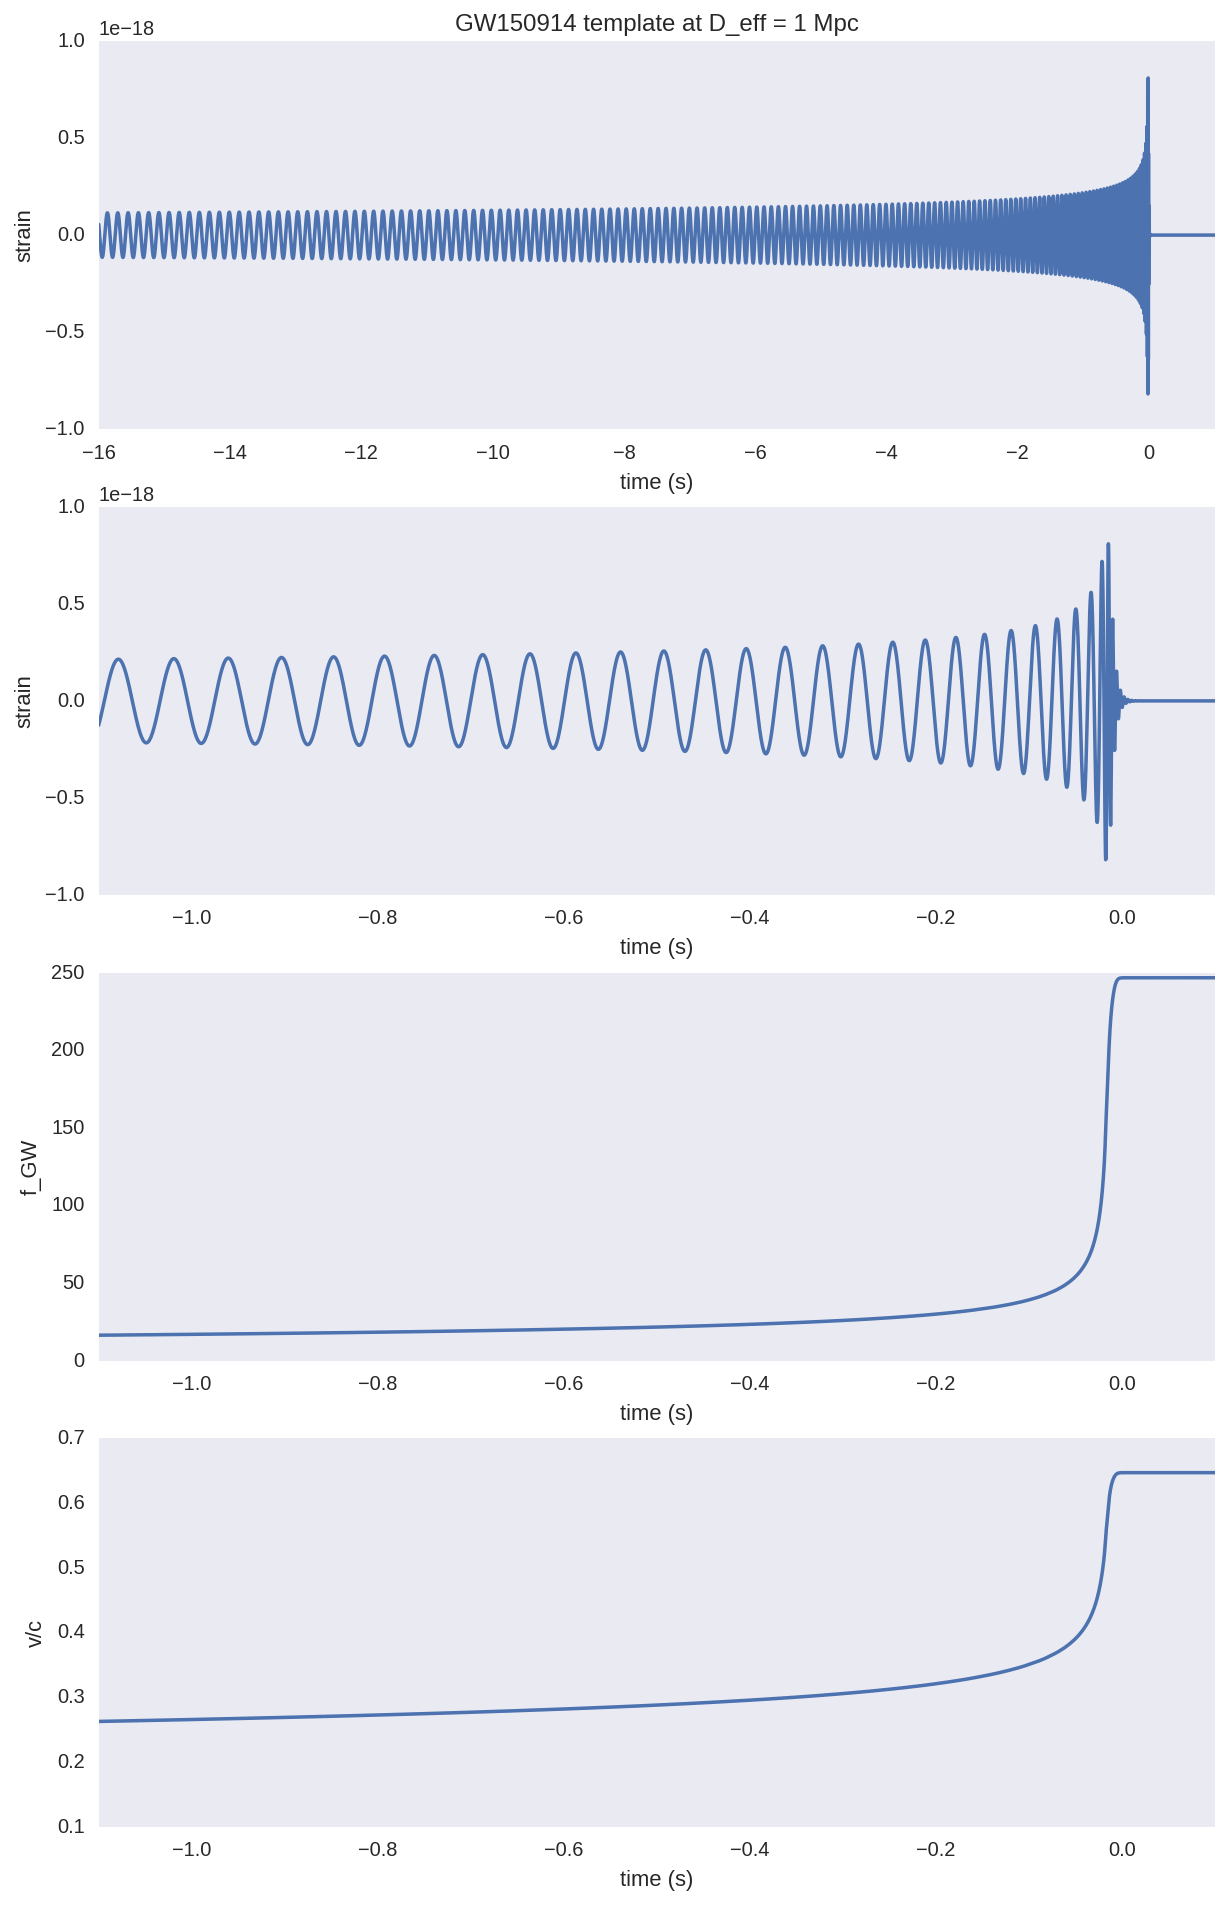

In [22]:
fig = plt.figure(figsize=(10,16))
plt.subplot(4,1,1)
plt.plot(time-time[0]-template_offset,template_p)
plt.xlim([-template_offset,1.])
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('strain')
plt.title(eventname+' template at D_eff = 1 Mpc')

plt.subplot(4,1,2)
plt.plot(ttime,template_p)
plt.xlim([-1.1,0.1])
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('strain')
#plt.title(eventname+' template at D_eff = 1 Mpc')

plt.subplot(4,1,3)
plt.plot(ttime,fGW)
plt.xlim([-1.1,0.1])
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('f_GW')
#plt.title(eventname+' template f_GW')

plt.subplot(4,1,4)
plt.plot(ttime,voverc)
plt.xlim([-1.1,0.1])
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('v/c')
#plt.title(eventname+' template v/c')
plt.savefig(eventname+'_template.'+plottype)

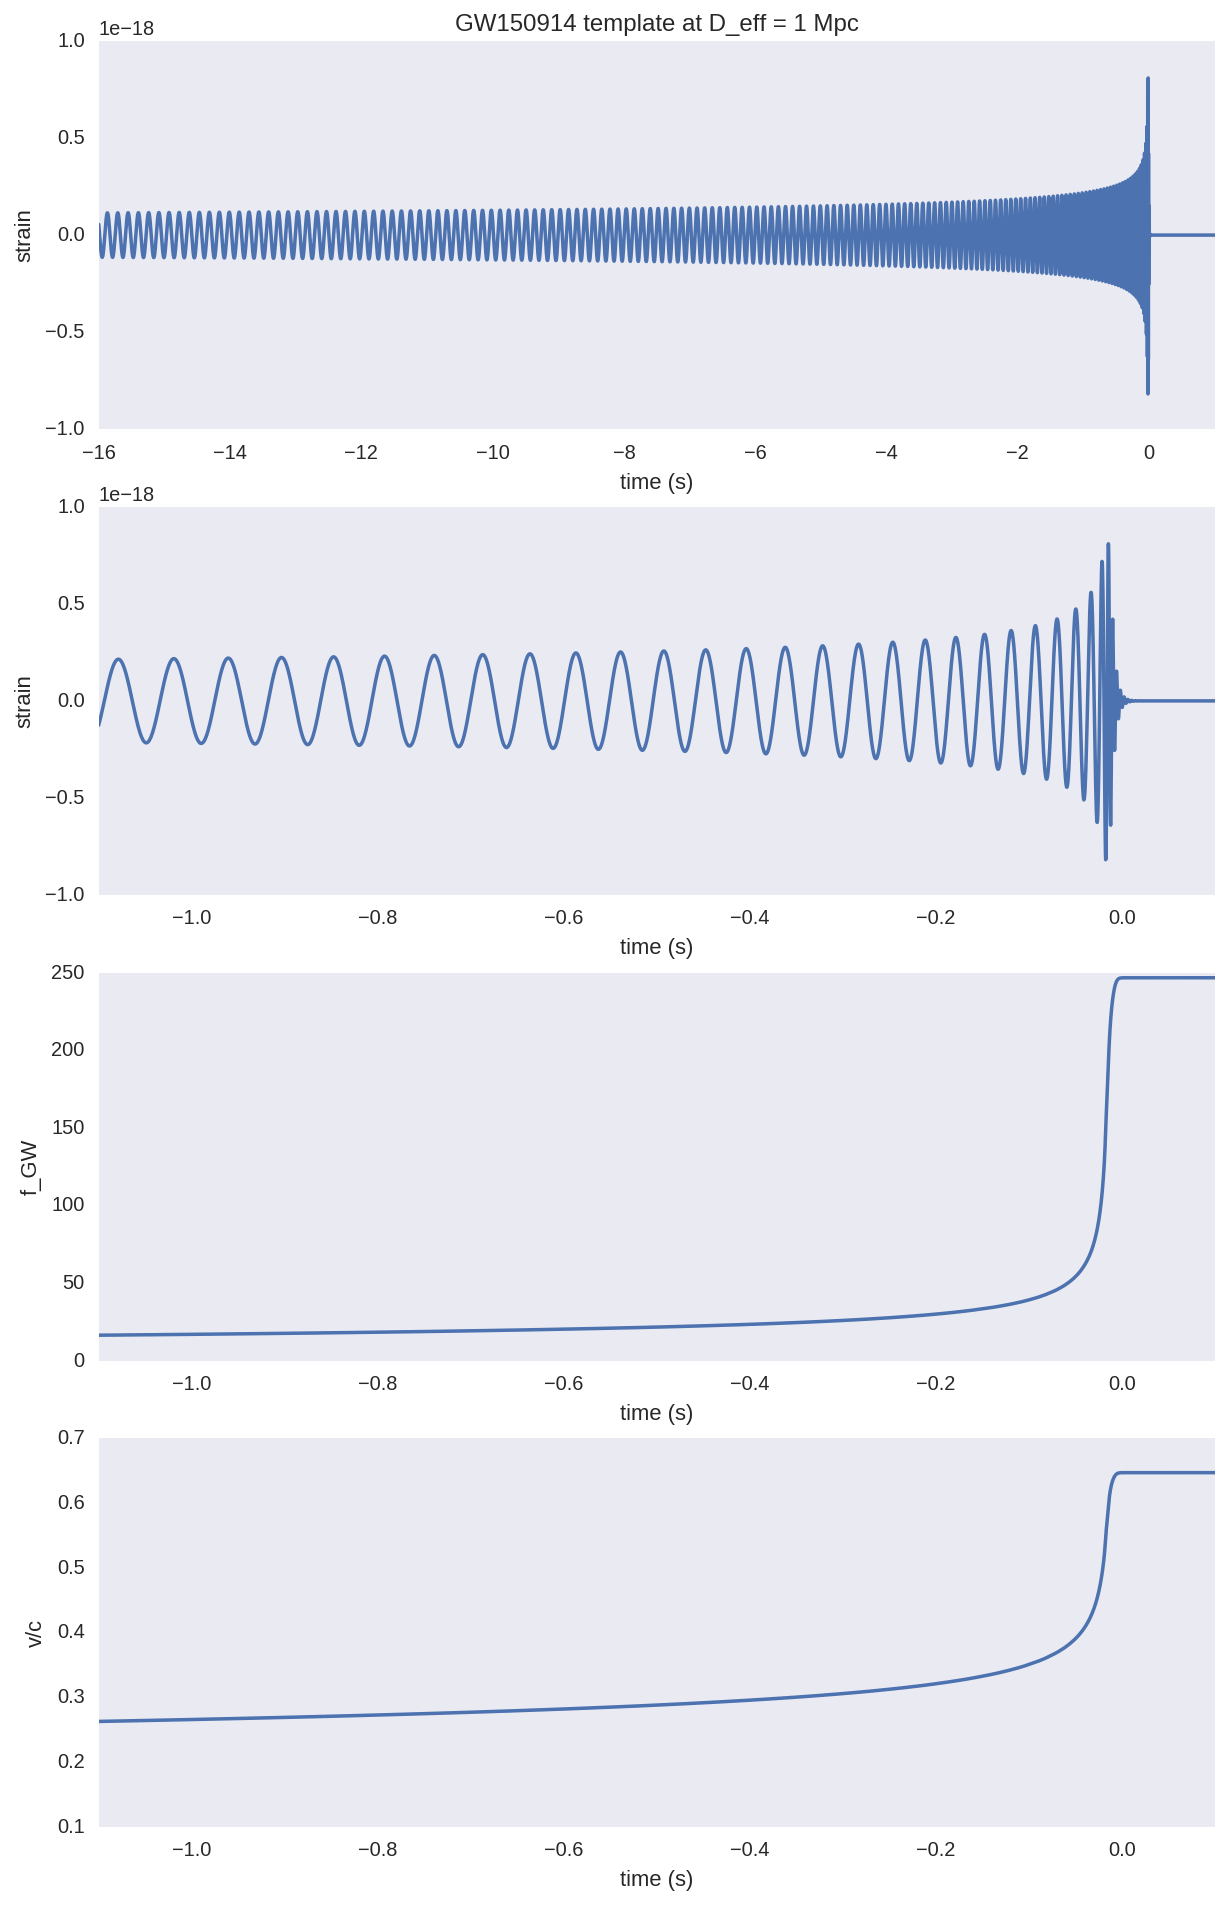

In [23]:
fig

## 3-4 理論モデルと観測データの検証
<img src="pyconfig4.png">

- ### 理論の波と観測の波の一致検証には，"Matched Filtering"という手法をとる
- ### 理論の波形と観測の波形は同じ = 周波数空間でみるとある点だけの「相関値」が高くなる
- ### その周波数空間の相関値が"SNR"
- ### 以下はH1だけを考える

- ### 理論（テンプレート）の用意

In [24]:
NFFT = 4*fs
psd_window = np.blackman(NFFT)
NOVL = NFFT/2

# define the complex template, common to both detectors:
template = (template_p + template_c*1.j) 
etime = time+template_offset
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

dwindow = signal.tukey(template.size, alpha=1./8) 

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs

- ### 白色化された観測値の用意

In [25]:
det = 'H1'
data = strain_H1.copy()

data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
data_fft = np.fft.fft(data*dwindow) / fs

power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

- ### SNRを計算

In [26]:
optimal = data_fft * template_fft.conjugate() / power_vec
optimal_time = 2*np.fft.ifft(optimal)*fs

sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR_complex = optimal_time/sigma

peaksample = int(data.size / 2)  # location of peak in the template
SNR_complex = np.roll(SNR_complex,peaksample)
SNR = abs(SNR_complex)

- ### SNRをプロット

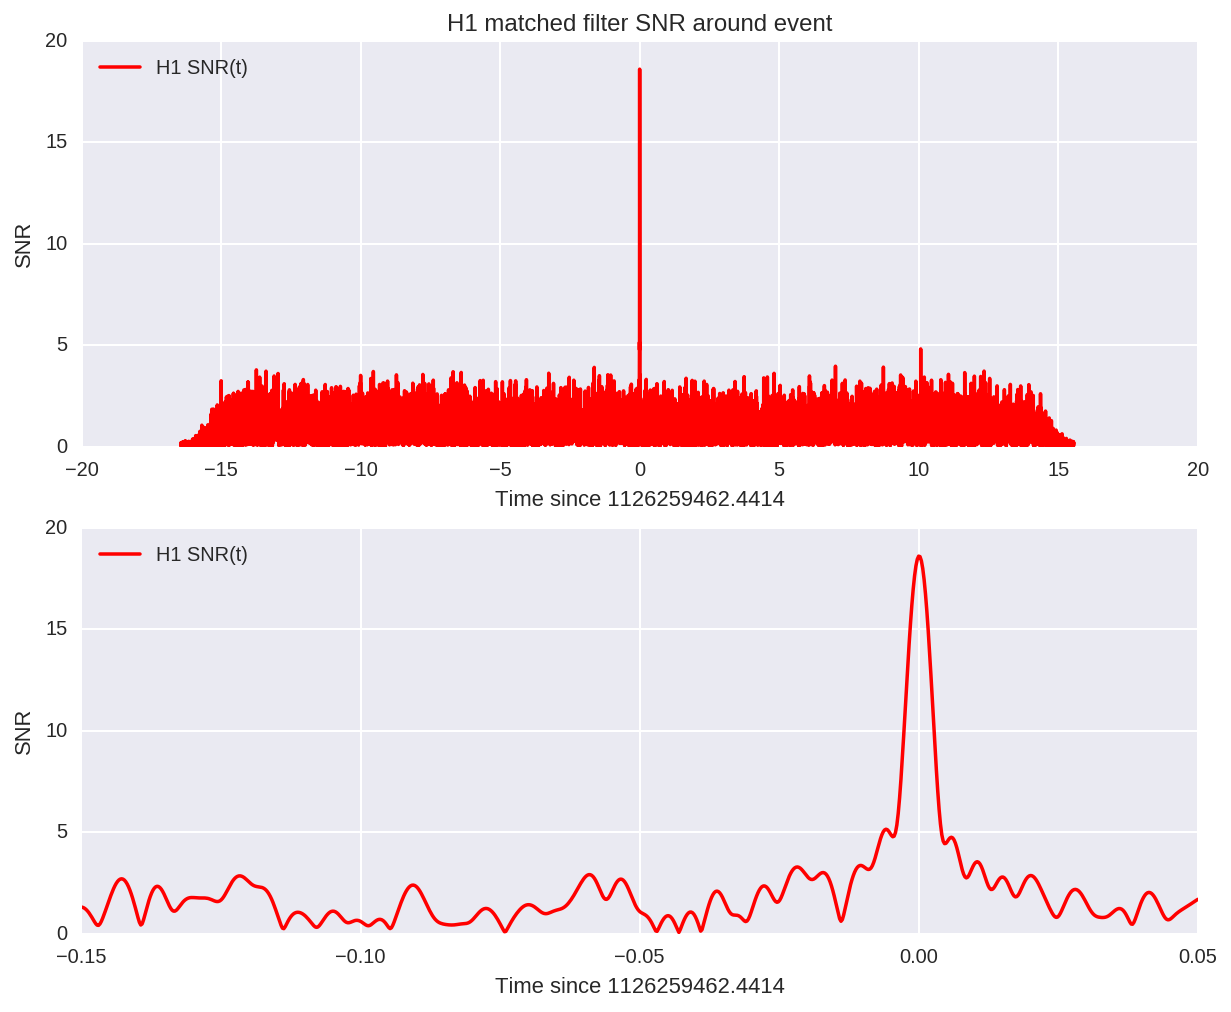

In [35]:
pcolor='r'

indmax = np.argmax(SNR)
timemax = time[indmax]

# -- Plot the result
fig1 = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(time-timemax, SNR, pcolor,label=det+' SNR(t)')
#plt.ylim([0,25.])
plt.grid('on')
plt.ylabel('SNR')
plt.xlabel('Time since {0:.4f}'.format(timemax))
plt.legend(loc='upper left')
plt.title(det+' matched filter SNR around event')

# zoom in
plt.subplot(2,1,2)
plt.plot(time-timemax, SNR, pcolor,label=det+' SNR(t)')
plt.grid('on')
plt.ylabel('SNR')
plt.xlim([-0.15,0.05])
#plt.xlim([-0.3,+0.3])
plt.grid('on')
plt.xlabel('Time since {0:.4f}'.format(timemax))
plt.legend(loc='upper left')
plt.savefig(eventname+"_"+det+"_SNR."+plottype)

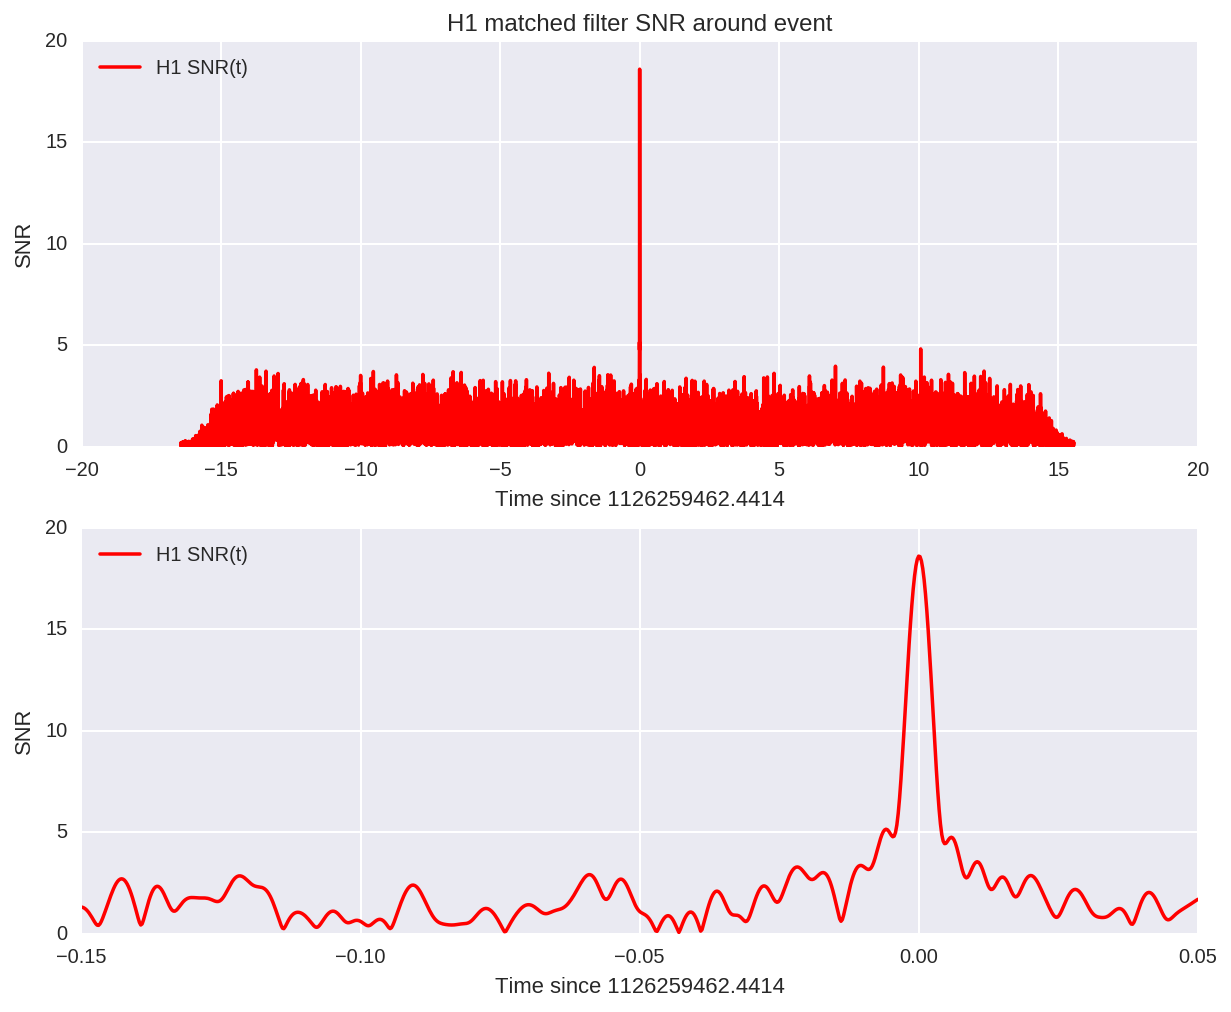

In [36]:
fig1

- ### 相対時間0だけに高いSNR -> 理論と観測は一致！

- ### 最大値をとるSNRと時間もとめる．

In [31]:
SNRmax = SNR[indmax]

d_eff = sigma / SNRmax
horizon = sigma/8

phase = np.angle(SNR_complex[indmax])
offset = (indmax-peaksample)
template_whitened = (template_p_whitenbp + template_c_whitenbp*1.j) 
template_phaseshifted = np.real(template_whitened*np.exp(1j*phase))
template_match = np.roll(template_phaseshifted,offset) / d_eff

print('For detector {0}, maximum at {1:.4f} with SNR = {2:.1f}, D_eff = {3:.2f}, horizon = {4:0.1f} Mpc' 
      .format(det,timemax,SNRmax,d_eff,horizon))

For detector H1, maximum at 1126259462.4414 with SNR = 18.6, D_eff = 805.83, horizon = 1873.7 Mpc


- ### 時間波形を理論と観測で重ねてみる．

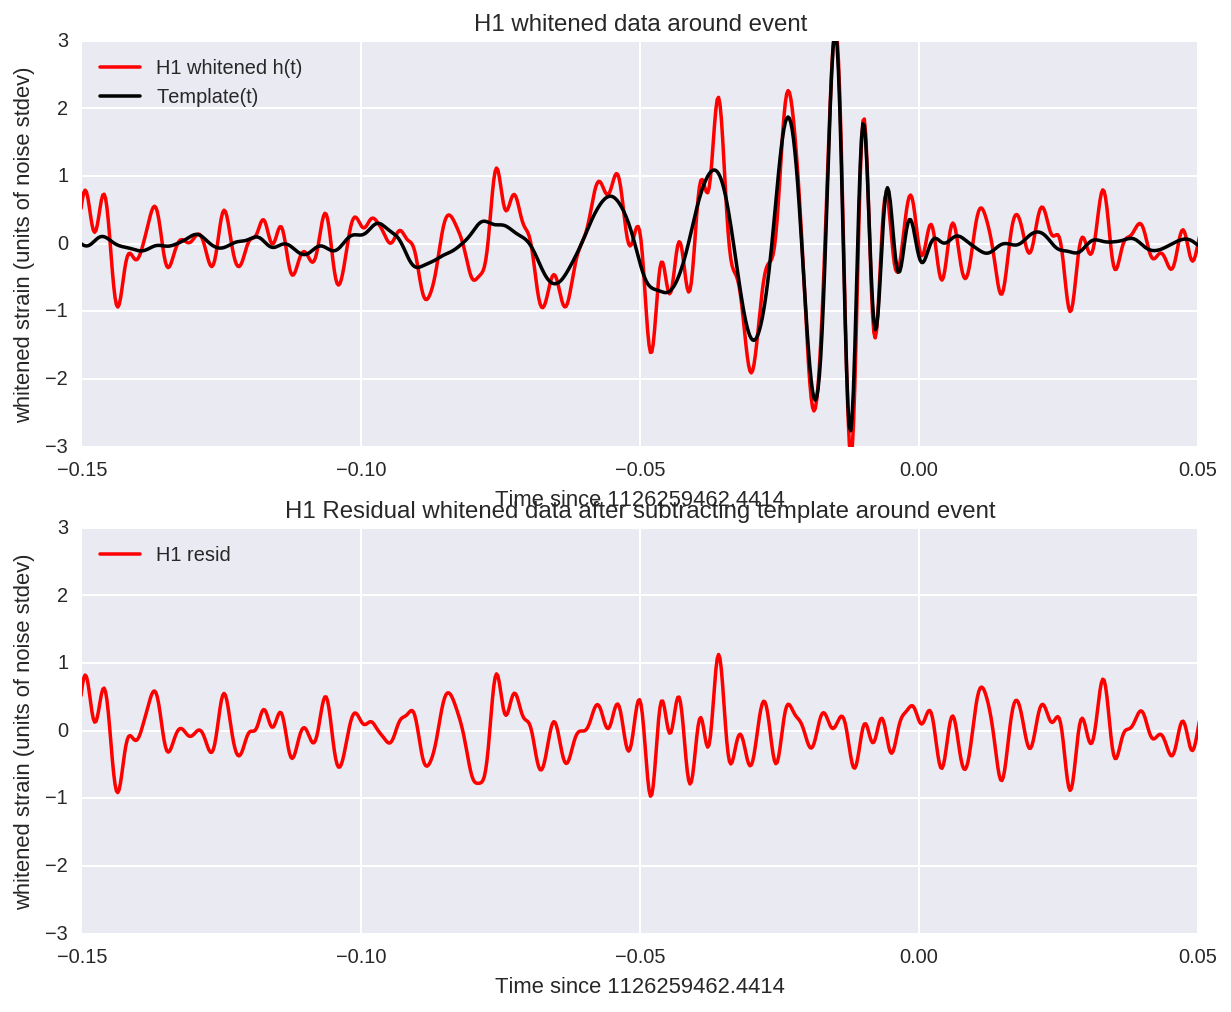

In [37]:
fig2 = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(time-tevent,strain_H1_whitenbp,pcolor,label=det+' whitened h(t)')
plt.plot(time-tevent,template_match,'k',label='Template(t)')
plt.ylim([-3,3])
plt.xlim([-0.15,0.05])
plt.grid('on')
plt.xlabel('Time since {0:.4f}'.format(timemax))
plt.ylabel('whitened strain (units of noise stdev)')
plt.legend(loc='upper left')
plt.title(det+' whitened data around event')

plt.subplot(2,1,2)
plt.plot(time-tevent,strain_H1_whitenbp-template_match,pcolor,label=det+' resid')
plt.ylim([-3,3])
plt.xlim([-0.15,0.05])
plt.grid('on')
plt.xlabel('Time since {0:.4f}'.format(timemax))
plt.ylabel('whitened strain (units of noise stdev)')
plt.legend(loc='upper left')
plt.title(det+' Residual whitened data after subtracting template around event')
plt.savefig(eventname+"_"+det+"_matchtime."+plottype)

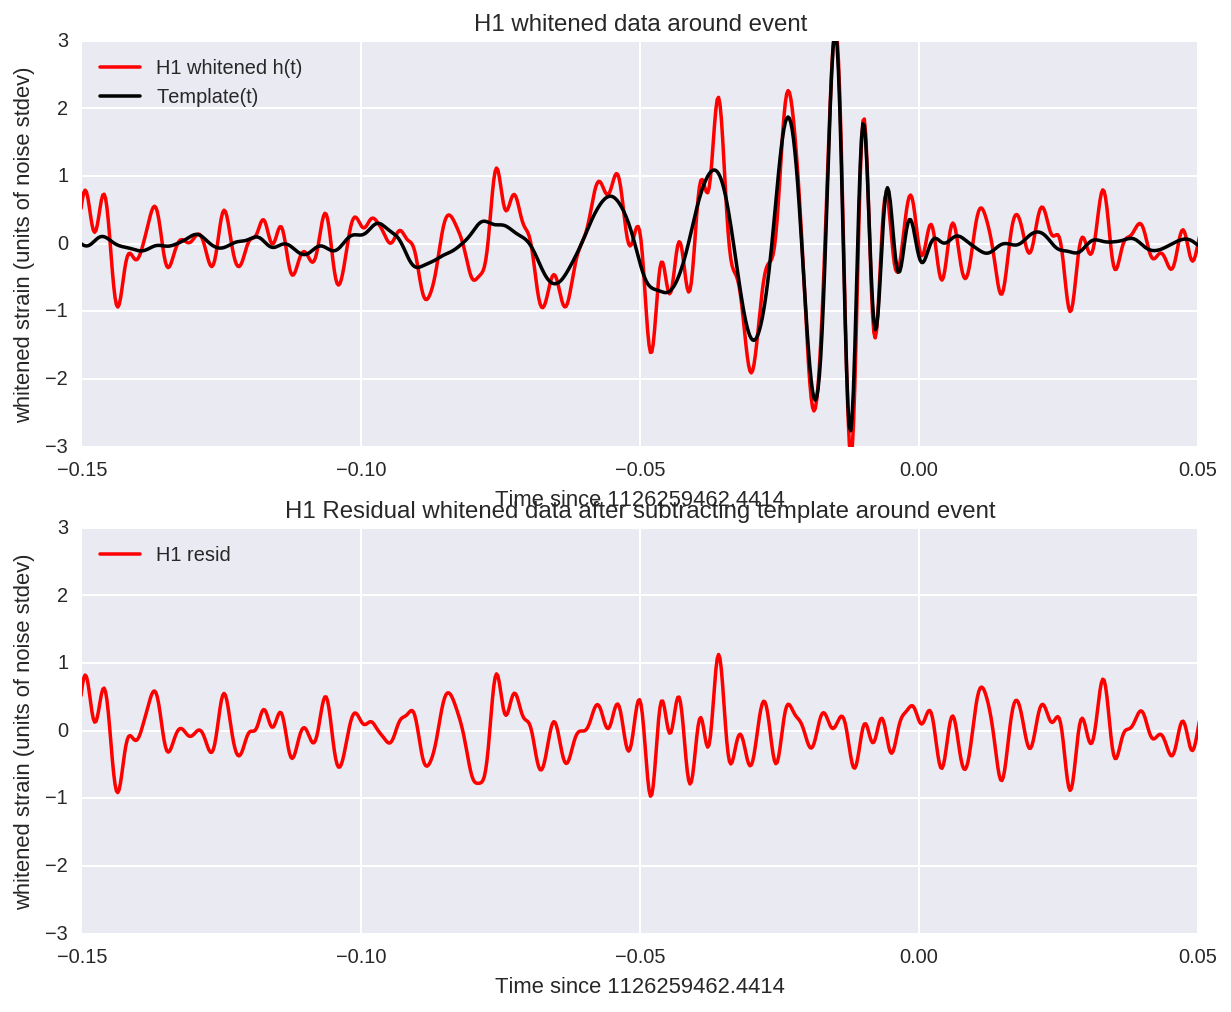

In [38]:
fig2

- ### こちらも明らかに一致

## 3-5 余興
- ### 重力波の音を聞く

In [33]:
# make wav (sound) files from the whitened data, +-2s around the event.

from scipy.io import wavfile

# function to keep the data within integer limits, and write to wavfile:
def write_wavfile(filename,fs,data):
    d = np.int16(data/np.max(np.abs(data)) * 32767 * 0.9)
    wavfile.write(filename,int(fs), d)

deltat_sound = 2.                     # seconds around the event

# index into the strain time series for this time interval:
indxd = np.where((time >= tevent-deltat_sound) & (time < tevent+deltat_sound))

# write the files:
write_wavfile(eventname+"_H1_whitenbp.wav",int(fs), strain_H1_whitenbp[indxd])
write_wavfile(eventname+"_L1_whitenbp.wav",int(fs), strain_L1_whitenbp[indxd])

# re-whiten the template using the smoothed PSD; it sounds better!
template_p_smooth = whiten(template_p,psd_smooth,dt)

# and the template, sooming in on [-3,+1] seconds around the merger:
indxt = np.where((time >= (time[0]+template_offset-deltat_sound)) & (time < (time[0]+template_offset+deltat_sound)))
write_wavfile(eventname+"_template_whiten.wav",int(fs), template_p_smooth[indxt])
#plt.plot(template_p_smooth[indxt])

# function that shifts frequency of a band-passed signal
def reqshift(data,fshift=100,sample_rate=4096):
    """Frequency shift the signal by constant
    """
    x = np.fft.rfft(data)
    T = len(data)/float(sample_rate)
    df = 1.0/T
    nbins = int(fshift/df)
    # print T,df,nbins,x.real.shape
    y = np.roll(x.real,nbins) + 1j*np.roll(x.imag,nbins)
    y[0:nbins]=0.
    z = np.fft.irfft(y)
    return z

# parameters for frequency shift
fs = 4096
fshift = 400.
speedup = 1.
fss = int(float(fs)*float(speedup))

# shift frequency of the data
strain_H1_shifted = reqshift(strain_H1_whitenbp,fshift=fshift,sample_rate=fs)
strain_L1_shifted = reqshift(strain_L1_whitenbp,fshift=fshift,sample_rate=fs)

# write the files:
write_wavfile(eventname+"_H1_shifted.wav",int(fs), strain_H1_shifted[indxd])
write_wavfile(eventname+"_L1_shifted.wav",int(fs), strain_L1_shifted[indxd])

# and the template:
template_p_shifted = reqshift(template_p_smooth,fshift=fshift,sample_rate=fs)
write_wavfile(eventname+"_template_shifted.wav",int(fs), template_p_shifted[indxt])

In [34]:
fna = eventname+"_template_shifted.wav"
print(fna)
from IPython.display import Audio
Audio(fna)

GW150914_template_shifted.wav
